In [1]:
import pandas as pd
import numpy as np
from datetime import date

In [2]:
df_off = pd.read_csv('ccf_offline_stage1_train.csv')
df_test = pd.read_csv('ccf_offline_stage1_test_revised.csv')

In [ ]:
df_off.head(10)

In [ ]:
df_test.head(10)

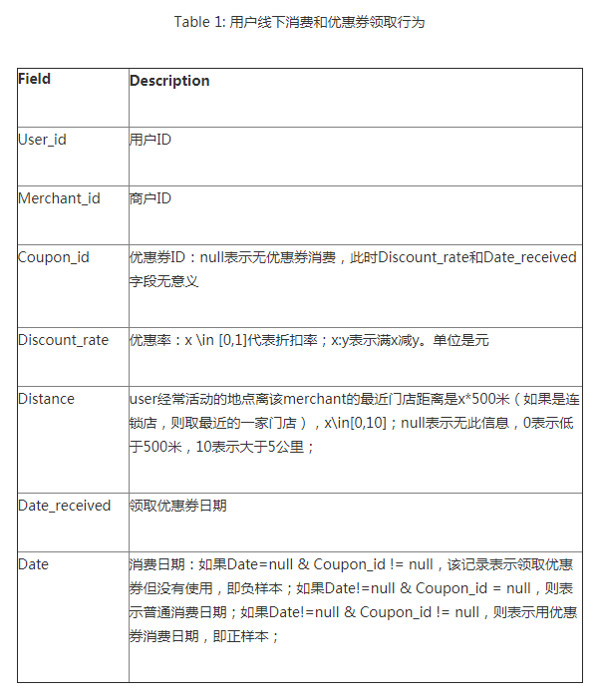

In [ ]:
print("有优惠券：{}".format(df_off.Date_received.isnull().value_counts()[0]))
print("没有优惠券：{}".format(df_off.Date_received.isnull().value_counts()[1]))

In [ ]:
print("购买商品：{}".format(df_off.Date.isnull().value_counts()[0]))
print("未购买商品：{}".format(df_off.Date.isnull().value_counts()[1]))

In [ ]:
print("有优惠券，购买商品：{}".format(df_off[df_off.Date_received.notnull() & df_off.Date.notnull()].shape[0]))
print("有优惠券，未购买商品：{}".format(df_off[df_off.Date_received.notnull() & df_off.Date.isnull()].shape[0]))
print("没有优惠券，购买商品：{}".format(df_off[df_off.Date_received.isnull() & df_off.Date.notnull()].shape[0]))
print("没有优惠券，未购买商品：{}".format(df_off[df_off.Date_received.isnull() & df_off.Date.isnull()].shape[0]))

In [3]:
#将年月日提取出来
def get_year_month_day(df):
    df['year'] = df.Date_received.astype(str).apply(lambda x:0 if x == 'nan' else int(x[0:4]) )
    df['month'] = df.Date_received.astype(str).apply(lambda x:0 if x == 'nan' else int(x[4:6]))
    df['day'] = df.Date_received.astype(str).apply(lambda x:0 if x == 'nan' else int(x[6:8]))
    return df

df_off = get_year_month_day(df_off)
df_test = get_year_month_day(df_test)

### 提取特征

In [4]:
#每个顾客使用优惠券的频率:单独使用掉优惠券的概率,一个月内使用劵的概率
#领劵的次数，领劵的数量，领劵的时间，一个月内领劵的数量，领同样的券的数量前后时间等等
#统计用户一个月以来领到的券的总数
def get_all_coupon_count(df):
    t = df[df.Coupon_id.notnull()][['User_id']]
    t['user_receive_all_coupon_count'] = 1
    return t.groupby('User_id').agg('sum').reset_index()

def get_all_coupon_use_count(df):
    t = df[df.Coupon_id.notnull()&df.Date.notnull()][['User_id']]
    t['user_use_all_coupon_count'] = 1
    return t.groupby('User_id').agg('sum').reset_index()

def get_all_same_coupon_count(df):
    t = df[df.Coupon_id.notnull()][['User_id', 'Coupon_id']]
    t['user_receive_same_coupon_count'] = 1
    return t.groupby(['User_id', 'Coupon_id']).agg('sum').reset_index()

def get_all_same_coupon_use_count(df):
    t = df[df.Coupon_id.notnull()&df.Date.notnull()][['User_id', 'Coupon_id']]
    t['user_use_same_coupon_count'] = 1
    return t.groupby(['User_id', 'Coupon_id']).agg('sum').reset_index()

def get_month_all_coupon_count(df):
    t = df[df.Coupon_id.notnull()][['User_id', 'month']]
    t['this_month_user_receive_all_coupon_count'] = 1
    return t.groupby(['User_id', 'month']).agg('sum').reset_index()

def get_month_same_coupon_count(df):
    t = df[df.Coupon_id.notnull()][['User_id', 'Coupon_id',  'month']]
    t['this_month_user_receive_same_coupon_count'] = 1
    return t.groupby(['User_id', 'Coupon_id', 'month']).agg('sum').reset_index()

def fill(df):
    df.user_use_all_coupon_rate.fillna(0, inplace=True)
    df.user_use_same_coupon_rate.fillna(0, inplace=True)
    df.user_use_all_coupon_count.fillna(0, inplace=True)
    df.user_use_same_coupon_count.fillna(0, inplace=True)
    df.user_receive_all_coupon_count.fillna(0, inplace=True)
    df.user_receive_same_coupon_count.fillna(0, inplace=True)
    df.this_month_user_receive_all_coupon_count.fillna(0, inplace=True)
    df.this_month_user_receive_same_coupon_count.fillna(0, inplace=True)
    return df

In [5]:
t1 = get_month_all_coupon_count(df_off)
t3 = get_month_same_coupon_count(df_off)
t5 = get_all_coupon_count(df_off)
t6 = get_all_coupon_use_count(df_off)
t7 = get_all_same_coupon_count(df_off)
t8 = get_all_same_coupon_use_count(df_off)

t9 = get_all_coupon_count(df_test)
t10 = get_all_same_coupon_count(df_test)
t11 = get_month_all_coupon_count(df_test)
t12 = get_month_same_coupon_count(df_test)

t13 = pd.merge(t5, t6, on = 'User_id')
t14 = pd.merge(t7, t8, on = ['User_id', 'Coupon_id'])
t = pd.merge(t13, t14, on='User_id')
df_off = pd.merge(df_off, t, on = ['User_id', 'Coupon_id'], how='left')
df_off['user_use_all_coupon_rate'] = df_off.user_use_all_coupon_count / df_off.user_receive_all_coupon_count
df_off['user_use_same_coupon_rate'] = df_off.user_use_same_coupon_count / df_off.user_receive_same_coupon_count
#df_off.drop(['user_use_all_coupon_count', 'user_use_same_coupon_count'], axis=1, inplace=True)

df_off = pd.merge(df_off, t1, on = ['User_id', 'month'], how='left')
df_off = pd.merge(df_off, t3, on = ['User_id', 'Coupon_id', 'month'], how='left')
df_off = fill(df_off)
df_off.head(10)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,year,month,day,user_receive_all_coupon_count,user_use_all_coupon_count,user_receive_same_coupon_count,user_use_same_coupon_count,user_use_all_coupon_rate,user_use_same_coupon_rate,this_month_user_receive_all_coupon_count,this_month_user_receive_same_coupon_count
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN,2016,5,28,0.0,0.0,0.0,0.0,0.0,0.000000,2.0,1.0
2,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,2016,2,17,5.0,1.0,3.0,1.0,0.2,0.333333,1.0,1.0
3,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,2016,3,19,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0
4,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN,2016,6,13,5.0,1.0,3.0,1.0,0.2,0.333333,1.0,1.0
5,1439408,2632,NaN,NaN,0.0,NaN,20160516.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
6,1439408,2632,8591.0,20:1,0.0,20160516.0,20160613.0,2016,5,16,5.0,1.0,3.0,1.0,0.2,0.333333,2.0,1.0
7,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN,2016,4,29,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0
8,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,2016,1,29,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0
9,2029232,450,1532.0,30:5,0.0,20160530.0,NaN,2016,5,30,0.0,0.0,0.0,0.0,0.0,0.000000,2.0,1.0


In [6]:
t = pd.merge(t9, t10, on = 'User_id')
df_test = pd.merge(df_test, t, on = ['User_id', 'Coupon_id'], how='left')
t = df_off[['User_id', 'user_use_all_coupon_rate']]
df_test = pd.merge(df_test, t, on='User_id', how='left')
t = df_off[['User_id', 'user_use_same_coupon_rate', 'Coupon_id']]
df_test = pd.merge(df_test, t, on = ['User_id', 'Coupon_id'], how='left')
t = pd.merge(t11, t12, on=['User_id', 'month'])
df_test = pd.merge(df_test, t, on = ['User_id', 'Coupon_id', 'month'], how='left')
df_test['user_use_all_coupon_count'] = df_test.user_receive_all_coupon_count * df_test.user_use_all_coupon_rate
df_test['user_use_same_coupon_count'] = df_test.user_receive_same_coupon_count * df_test.user_use_same_coupon_rate
df_test = fill(df_test)
df_test.head(20)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,year,month,day,user_receive_all_coupon_count,user_receive_same_coupon_count,user_use_all_coupon_rate,user_use_same_coupon_rate,this_month_user_receive_all_coupon_count,this_month_user_receive_same_coupon_count,user_use_all_coupon_count,user_use_same_coupon_count
0,4129537,450,9983,30:5,1.0,20160712,2016,7,12,1,1,0.0,0.0,1,1,0.0,0.0
1,4129537,450,9983,30:5,1.0,20160712,2016,7,12,1,1,0.0,0.0,1,1,0.0,0.0
2,6949378,1300,3429,30:5,NaN,20160706,2016,7,6,1,1,0.0,0.0,1,1,0.0,0.0
3,6949378,1300,3429,30:5,NaN,20160706,2016,7,6,1,1,1.0,0.0,1,1,1.0,0.0
4,2166529,7113,6928,200:20,5.0,20160727,2016,7,27,2,1,0.0,0.0,2,1,0.0,0.0
5,2166529,7113,1808,100:10,5.0,20160727,2016,7,27,2,1,0.0,0.0,2,1,0.0,0.0
6,6172162,7605,6500,30:1,2.0,20160708,2016,7,8,1,1,0.0,0.0,1,1,0.0,0.0
7,6172162,7605,6500,30:1,2.0,20160708,2016,7,8,1,1,0.0,0.0,1,1,0.0,0.0
8,6172162,7605,6500,30:1,2.0,20160708,2016,7,8,1,1,0.0,0.0,1,1,0.0,0.0
9,6172162,7605,6500,30:1,2.0,20160708,2016,7,8,1,1,0.0,0.0,1,1,0.0,0.0


In [7]:
t = df_test.user_use_all_coupon_count
df_test.drop('user_use_all_coupon_count', axis=1, inplace=True)
df_test.insert(10, 'user_use_all_coupon_count', t)
df_test.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,year,month,day,user_receive_all_coupon_count,user_use_all_coupon_count,user_receive_same_coupon_count,user_use_all_coupon_rate,user_use_same_coupon_rate,this_month_user_receive_all_coupon_count,this_month_user_receive_same_coupon_count,user_use_same_coupon_count
0,4129537,450,9983,30:5,1.0,20160712,2016,7,12,1,0.0,1,0.0,0.0,1,1,0.0
1,4129537,450,9983,30:5,1.0,20160712,2016,7,12,1,0.0,1,0.0,0.0,1,1,0.0
2,6949378,1300,3429,30:5,NaN,20160706,2016,7,6,1,0.0,1,0.0,0.0,1,1,0.0
3,6949378,1300,3429,30:5,NaN,20160706,2016,7,6,1,1.0,1,1.0,0.0,1,1,0.0
4,2166529,7113,6928,200:20,5.0,20160727,2016,7,27,2,0.0,1,0.0,0.0,2,1,0.0


In [8]:
t = df_test.user_use_same_coupon_count
df_test.drop('user_use_same_coupon_count', axis=1, inplace=True)
df_test.insert(12, 'user_use_same_coupon_count', t)
df_test.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,year,month,day,user_receive_all_coupon_count,user_use_all_coupon_count,user_receive_same_coupon_count,user_use_same_coupon_count,user_use_all_coupon_rate,user_use_same_coupon_rate,this_month_user_receive_all_coupon_count,this_month_user_receive_same_coupon_count
0,4129537,450,9983,30:5,1.0,20160712,2016,7,12,1,0.0,1,0.0,0.0,0.0,1,1
1,4129537,450,9983,30:5,1.0,20160712,2016,7,12,1,0.0,1,0.0,0.0,0.0,1,1
2,6949378,1300,3429,30:5,NaN,20160706,2016,7,6,1,0.0,1,0.0,0.0,0.0,1,1
3,6949378,1300,3429,30:5,NaN,20160706,2016,7,6,1,1.0,1,0.0,1.0,0.0,1,1
4,2166529,7113,6928,200:20,5.0,20160727,2016,7,27,2,0.0,1,0.0,0.0,0.0,2,1


In [9]:
#商品的种类，商品的营销额，商户的距离等等
mi = df_off[['Merchant_id', 'Coupon_id', 'Date']]

t1 = mi[mi.Date.notnull()][['Merchant_id']]
t1['total_sales'] = 1
t1 = t1.groupby('Merchant_id').agg('sum').reset_index()
df_off = pd.merge(df_off, t1, on='Merchant_id', how='left')

t2 = mi[mi.Date.notnull()&mi.Coupon_id.notnull()][['Merchant_id']]
t2['sales_use_coupon'] = 1
t2 = t2.groupby('Merchant_id').agg('sum').reset_index()
df_off = pd.merge(df_off, t2, on='Merchant_id', how='left')

t3 = mi[mi.Coupon_id.notnull()][['Merchant_id']]
t3['total_coupon'] = 1
t3 = t3.groupby('Merchant_id').agg('sum').reset_index()
df_off = pd.merge(df_off, t3, on='Merchant_id', how='left')

#df_off['coupon_rate'] = df_off.sales_use_coupon / df_off.total_sales
#df_off['tranfer_rate'] = df_off.sales_use_coupon / df_off.total_coupon
df_off.drop(['total_sales', 'sales_use_coupon'], axis=1, inplace=True)
df_off.head(10)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,year,month,day,user_receive_all_coupon_count,user_use_all_coupon_count,user_receive_same_coupon_count,user_use_same_coupon_count,user_use_all_coupon_rate,user_use_same_coupon_rate,this_month_user_receive_all_coupon_count,this_month_user_receive_same_coupon_count,total_coupon
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,43.0
1,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN,2016,5,28,0.0,0.0,0.0,0.0,0.0,0.000000,2.0,1.0,15191.0
2,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,2016,2,17,5.0,1.0,3.0,1.0,0.2,0.333333,1.0,1.0,43.0
3,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,2016,3,19,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,43.0
4,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN,2016,6,13,5.0,1.0,3.0,1.0,0.2,0.333333,1.0,1.0,43.0
5,1439408,2632,NaN,NaN,0.0,NaN,20160516.0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,43.0
6,1439408,2632,8591.0,20:1,0.0,20160516.0,20160613.0,2016,5,16,5.0,1.0,3.0,1.0,0.2,0.333333,2.0,1.0,43.0
7,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN,2016,4,29,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,122834.0
8,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,2016,1,29,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,1.0,122834.0
9,2029232,450,1532.0,30:5,0.0,20160530.0,NaN,2016,5,30,0.0,0.0,0.0,0.0,0.0,0.000000,2.0,1.0,63042.0


In [10]:
t3 = df_test[['Merchant_id']]
t3['total_coupon'] = 1
t3 = t3.groupby('Merchant_id').agg('sum').reset_index()
df_test = pd.merge(df_test, t3, on='Merchant_id', how='left')

C:\Users\wen\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
df_test.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,year,month,day,user_receive_all_coupon_count,user_use_all_coupon_count,user_receive_same_coupon_count,user_use_same_coupon_count,user_use_all_coupon_rate,user_use_same_coupon_rate,this_month_user_receive_all_coupon_count,this_month_user_receive_same_coupon_count,total_coupon
0,4129537,450,9983,30:5,1.0,20160712,2016,7,12,1,0.0,1,0.0,0.0,0.0,1,1,77767
1,4129537,450,9983,30:5,1.0,20160712,2016,7,12,1,0.0,1,0.0,0.0,0.0,1,1,77767
2,6949378,1300,3429,30:5,NaN,20160706,2016,7,6,1,0.0,1,0.0,0.0,0.0,1,1,32868
3,6949378,1300,3429,30:5,NaN,20160706,2016,7,6,1,1.0,1,0.0,1.0,0.0,1,1,32868
4,2166529,7113,6928,200:20,5.0,20160727,2016,7,27,2,0.0,1,0.0,0.0,0.0,2,1,1576


In [12]:
#门店距离
print(df_off.Distance.unique())
print(df_test.Distance.unique())

[ 0.  1. nan  2. 10.  4.  7.  9.  3.  5.  6.  8.]
[ 1. nan  5.  2.  0. 10.  3.  6.  7.  4.  9.  8.]


In [13]:
#填充空值
df_off['distance'] = df_off['Distance']
df_off.distance.fillna(-1, inplace=True)
print(df_off.distance.unique())
df_test['distance'] = df_test['Distance']
df_test.distance.fillna(-1, inplace=True)
print(df_test.distance.unique())

[ 0.  1. -1.  2. 10.  4.  7.  9.  3.  5.  6.  8.]
[ 1. -1.  5.  2.  0. 10.  3.  6.  7.  4.  9.  8.]


In [14]:
def process_distance(t):
    t.distance = t.distance.astype(int)
    t.replace(-1, np.nan, inplace=True)

    t1 = t.groupby('Merchant_id').agg('min').reset_index()
    t1.replace(np.nan, -1, inplace=True)
    t1.rename(columns={'distance':'mechant_min_distance'}, inplace=True)

    t2 = t.groupby('Merchant_id').agg('max').reset_index()
    t2.replace(np.nan, -1, inplace=True)
    t2.rename(columns={'distance':'mechant_max_distance'}, inplace=True)

    t3 = t.groupby('Merchant_id').agg('mean').reset_index()
    t3.replace(np.nan, -1, inplace=True)
    t3.rename(columns={'distance':'mechant_mean_distance'}, inplace=True)

    t4 = t.groupby('Merchant_id').agg('min').reset_index()
    t4.replace(np.nan, -1, inplace=True)
    t4.rename(columns={'distance':'mechant_median_distance'}, inplace=True)
    return t1, t2, t3, t4

#合并
def join(df, t):
    df = pd.merge(df, t, on='Merchant_id', how='left')
    return df

In [15]:
d = df_off[['Merchant_id', 'distance', 'Date', 'Date_received']]
t = df_off[df_off.Date.notnull()&df_off.Date_received.notnull()][['Merchant_id', 'distance']]
t1, t2, t3, t4 = process_distance(t)
df_off = join(df_off, t1)
df_off = join(df_off, t2)
df_off = join(df_off, t3)
df_off = join(df_off, t4)
df_off.head(20)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,year,month,day,...,user_use_all_coupon_rate,user_use_same_coupon_rate,this_month_user_receive_all_coupon_count,this_month_user_receive_same_coupon_count,total_coupon,distance,mechant_min_distance,mechant_max_distance,mechant_mean_distance,mechant_median_distance
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0,0,0,0,...,0.0,0.000000,0.0,0.0,43.0,0.0,0.0,1.0,0.750000,0.0
1,1439408,4663,11002.0,150:20,1.0,20160528.0,NaN,2016,5,28,...,0.0,0.000000,2.0,1.0,15191.0,1.0,0.0,10.0,2.073529,0.0
2,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,2016,2,17,...,0.2,0.333333,1.0,1.0,43.0,0.0,0.0,1.0,0.750000,0.0
3,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,2016,3,19,...,0.0,0.000000,1.0,1.0,43.0,0.0,0.0,1.0,0.750000,0.0
4,1439408,2632,8591.0,20:1,0.0,20160613.0,NaN,2016,6,13,...,0.2,0.333333,1.0,1.0,43.0,0.0,0.0,1.0,0.750000,0.0
5,1439408,2632,NaN,NaN,0.0,NaN,20160516.0,0,0,0,...,0.0,0.000000,0.0,0.0,43.0,0.0,0.0,1.0,0.750000,0.0
6,1439408,2632,8591.0,20:1,0.0,20160516.0,20160613.0,2016,5,16,...,0.2,0.333333,2.0,1.0,43.0,0.0,0.0,1.0,0.750000,0.0
7,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN,2016,4,29,...,0.0,0.000000,1.0,1.0,122834.0,0.0,0.0,10.0,1.652429,0.0
8,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,2016,1,29,...,0.0,0.000000,1.0,1.0,122834.0,1.0,0.0,10.0,1.652429,0.0
9,2029232,450,1532.0,30:5,0.0,20160530.0,NaN,2016,5,30,...,0.0,0.000000,2.0,1.0,63042.0,0.0,0.0,10.0,0.892164,0.0


In [16]:
t = df_test[['Merchant_id', 'distance']]
t1, t2, t3, t4 = process_distance(t)
df_test = join(df_test, t1)
df_test = join(df_test, t2)
df_test = join(df_test, t3)
df_test = join(df_test, t4)
df_test.head(20)

C:\Users\wen\Anaconda3\envs\tensorflow\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
C:\Users\wen\Anaconda3\envs\tensorflow\lib\site-packages\pandas\core\frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,year,month,day,user_receive_all_coupon_count,...,user_use_all_coupon_rate,user_use_same_coupon_rate,this_month_user_receive_all_coupon_count,this_month_user_receive_same_coupon_count,total_coupon,distance,mechant_min_distance,mechant_max_distance,mechant_mean_distance,mechant_median_distance
0,4129537,450,9983,30:5,1.0,20160712,2016,7,12,1,...,0.0,0.0,1,1,77767,1.0,0.0,10.0,3.145034,0.0
1,4129537,450,9983,30:5,1.0,20160712,2016,7,12,1,...,0.0,0.0,1,1,77767,1.0,0.0,10.0,3.145034,0.0
2,6949378,1300,3429,30:5,NaN,20160706,2016,7,6,1,...,0.0,0.0,1,1,32868,-1.0,0.0,10.0,3.394792,0.0
3,6949378,1300,3429,30:5,NaN,20160706,2016,7,6,1,...,1.0,0.0,1,1,32868,-1.0,0.0,10.0,3.394792,0.0
4,2166529,7113,6928,200:20,5.0,20160727,2016,7,27,2,...,0.0,0.0,2,1,1576,5.0,0.0,10.0,3.514768,0.0
5,2166529,7113,1808,100:10,5.0,20160727,2016,7,27,2,...,0.0,0.0,2,1,1576,5.0,0.0,10.0,3.514768,0.0
6,6172162,7605,6500,30:1,2.0,20160708,2016,7,8,1,...,0.0,0.0,1,1,1952,2.0,0.0,10.0,0.617534,0.0
7,6172162,7605,6500,30:1,2.0,20160708,2016,7,8,1,...,0.0,0.0,1,1,1952,2.0,0.0,10.0,0.617534,0.0
8,6172162,7605,6500,30:1,2.0,20160708,2016,7,8,1,...,0.0,0.0,1,1,1952,2.0,0.0,10.0,0.617534,0.0
9,6172162,7605,6500,30:1,2.0,20160708,2016,7,8,1,...,0.0,0.0,1,1,1952,2.0,0.0,10.0,0.617534,0.0


In [17]:
df_off.drop('Distance', axis=1, inplace=True)
df_test.drop('Distance', axis=1, inplace=True)

In [18]:
#优惠券的种类，优惠率之类的
#优惠券的种类以及所花出去的频率：不限时间的，每个月内的
ci = df_off[['Coupon_id', 'Date', 'month']]

t1 = ci[ci.Coupon_id.notnull()][['Coupon_id']]
t1['every_coupon_count'] = 1
t1 = t1.groupby('Coupon_id').agg('sum').reset_index()
df_off = pd.merge(df_off, t1, on='Coupon_id', how='left')

#t2 = ci[ci.Coupon_id.notnull()&ci.Date.notnull()][['Coupon_id']]
#t2['every_coupon_use_count'] = 1
#t2 = t2.groupby('Coupon_id').agg('sum').reset_index()
#df_off = pd.merge(df_off, t2, on='Coupon_id', how='left')
#df_off['every_coupon_use_rate'] = df_off.every_coupon_use_count / df_off.every_coupon_count

#t3 = ci[ci.Coupon_id.notnull()][['Coupon_id', 'month']]
#t3['every_month_coupon_count'] = 1
#t3 = t3.groupby(['Coupon_id', 'month']).agg('sum').reset_index()
#df_off = pd.merge(df_off, t3, on=['Coupon_id', 'month'], how='left')

#t4 = ci[ci.Coupon_id.notnull()&ci.Date.notnull()][['Coupon_id', 'month']]
#t4['every_month_coupon_use_count'] = 1
#t4 = t4.groupby(['Coupon_id', 'month']).agg('sum').reset_index()
#df_off = pd.merge(df_off, t4, on=['Coupon_id', 'month'], how='left')
#df_off['every_month_coupon_use_rate'] = df_off.every_month_coupon_use_count / df_off.every_month_coupon_count

df_off.every_coupon_count.fillna(0, inplace=True)
#df_off.every_coupon_use_count.fillna(0, inplace=True)
#df_off.every_coupon_use_rate.fillna(0, inplace=True)
#df_off.every_month_coupon_count.fillna(0, inplace=True)
#df_off.every_month_coupon_use_count.fillna(0, inplace=True)
#df_off.every_month_coupon_use_rate.fillna(0, inplace=True)

In [19]:
df_off.head(20)

,User_id,Merchant_id,Coupon_id,Discount_rate,Date_received,Date,year,month,day,user_receive_all_coupon_count,...,user_use_same_coupon_rate,this_month_user_receive_all_coupon_count,this_month_user_receive_same_coupon_count,total_coupon,distance,mechant_min_distance,mechant_max_distance,mechant_mean_distance,mechant_median_distance,every_coupon_count
0,1439408,2632,NaN,NaN,NaN,20160217.0,0,0,0,0.0,...,0.000000,0.0,0.0,43.0,0.0,0.0,1.0,0.750000,0.0,0.0
1,1439408,4663,11002.0,150:20,20160528.0,NaN,2016,5,28,0.0,...,0.000000,2.0,1.0,15191.0,1.0,0.0,10.0,2.073529,0.0,7730.0
2,1439408,2632,8591.0,20:1,20160217.0,NaN,2016,2,17,5.0,...,0.333333,1.0,1.0,43.0,0.0,0.0,1.0,0.750000,0.0,31.0
3,1439408,2632,1078.0,20:1,20160319.0,NaN,2016,3,19,0.0,...,0.000000,1.0,1.0,43.0,0.0,0.0,1.0,0.750000,0.0,12.0
4,1439408,2632,8591.0,20:1,20160613.0,NaN,2016,6,13,5.0,...,0.333333,1.0,1.0,43.0,0.0,0.0,1.0,0.750000,0.0,31.0
5,1439408,2632,NaN,NaN,NaN,20160516.0,0,0,0,0.0,...,0.000000,0.0,0.0,43.0,0.0,0.0,1.0,0.750000,0.0,0.0
6,1439408,2632,8591.0,20:1,20160516.0,20160613.0,2016,5,16,5.0,...,0.333333,2.0,1.0,43.0,0.0,0.0,1.0,0.750000,0.0,31.0
7,1832624,3381,7610.0,200:20,20160429.0,NaN,2016,4,29,0.0,...,0.000000,1.0,1.0,122834.0,0.0,0.0,10.0,1.652429,0.0,46729.0
8,2029232,3381,11951.0,200:20,20160129.0,NaN,2016,1,29,0.0,...,0.000000,1.0,1.0,122834.0,1.0,0.0,10.0,1.652429,0.0,26035.0
9,2029232,450,1532.0,30:5,20160530.0,NaN,2016,5,30,0.0,...,0.000000,2.0,1.0,63042.0,0.0,0.0,10.0,0.892164,0.0,13300.0


In [20]:
t1 = df_test[['Coupon_id']]
t1['every_coupon_count'] = 1
t1 = t1.groupby('Coupon_id').agg('sum').reset_index()
df_test = pd.merge(df_test, t1, on='Coupon_id', how='left')
#t2 = df_off[['Coupon_id', 'every_coupon_use_rate']]
#df_test = pd.merge(df_test, t2, on='Coupon_id', how='left')
df_test.head(20)

C:\Users\wen\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,User_id,Merchant_id,Coupon_id,Discount_rate,Date_received,year,month,day,user_receive_all_coupon_count,user_use_all_coupon_count,...,user_use_same_coupon_rate,this_month_user_receive_all_coupon_count,this_month_user_receive_same_coupon_count,total_coupon,distance,mechant_min_distance,mechant_max_distance,mechant_mean_distance,mechant_median_distance,every_coupon_count
0,4129537,450,9983,30:5,20160712,2016,7,12,1,0.0,...,0.0,1,1,77767,1.0,0.0,10.0,3.145034,0.0,73787
1,4129537,450,9983,30:5,20160712,2016,7,12,1,0.0,...,0.0,1,1,77767,1.0,0.0,10.0,3.145034,0.0,73787
2,6949378,1300,3429,30:5,20160706,2016,7,6,1,0.0,...,0.0,1,1,32868,-1.0,0.0,10.0,3.394792,0.0,31336
3,6949378,1300,3429,30:5,20160706,2016,7,6,1,1.0,...,0.0,1,1,32868,-1.0,0.0,10.0,3.394792,0.0,31336
4,2166529,7113,6928,200:20,20160727,2016,7,27,2,0.0,...,0.0,2,1,1576,5.0,0.0,10.0,3.514768,0.0,788
5,2166529,7113,1808,100:10,20160727,2016,7,27,2,0.0,...,0.0,2,1,1576,5.0,0.0,10.0,3.514768,0.0,788
6,6172162,7605,6500,30:1,20160708,2016,7,8,1,0.0,...,0.0,1,1,1952,2.0,0.0,10.0,0.617534,0.0,1952
7,6172162,7605,6500,30:1,20160708,2016,7,8,1,0.0,...,0.0,1,1,1952,2.0,0.0,10.0,0.617534,0.0,1952
8,6172162,7605,6500,30:1,20160708,2016,7,8,1,0.0,...,0.0,1,1,1952,2.0,0.0,10.0,0.617534,0.0,1952
9,6172162,7605,6500,30:1,20160708,2016,7,8,1,0.0,...,0.0,1,1,1952,2.0,0.0,10.0,0.617534,0.0,1952


In [21]:
#优惠率
#分为打折，满减和不优惠三种模式
#影响人的购买程度
df_off.Discount_rate.unique()

array([nan, '150:20', '20:1', '200:20', '30:5', '50:10', '10:5', '100:10',
       '200:30', '20:5', '30:10', '50:5', '150:10', '100:30', '200:50',
       '100:50', '300:30', '50:20', '0.9', '10:1', '30:1', '0.95',
       '100:5', '5:1', '100:20', '0.8', '50:1', '200:10', '300:20',
       '100:1', '150:30', '300:50', '20:10', '0.85', '0.6', '150:50',
       '0.75', '0.5', '200:5', '0.7', '30:20', '300:10', '0.2', '50:30',
       '200:100', '150:5'], dtype=object)

In [22]:
#获取大折扣的类型：0代表不打折扣，1代表采用折扣比率，2表示满减的形式
def get_discount_type(s):
    s = str(s)
    if s == 'null':
        return 0.0
    elif ':' in s:
        return 1.0
    else:
        return 2.0

#计算满减的折扣率，用比例来展现会比较直观，因为有券购买商品的人数太少，用满减的门槛来定义显得有些过于刻意
def cal_discount_rate(s):
    s = str(s)
    if s == 'null':
        return 1.0
    else:
        s = s.split(':')
        if len(s) == 1:
            return float(s[0])
        else:
            return 1.0 - float(s[1]) / float(s[0])
    
#获取满减的门槛
def get_discount_man(s):
    s = str(s)
    if ':' in s:
        s = s.split(':')
        return float(s[0])
    else:
        return 0.0
    
#获取满减的钱数：
def get_discount_jian(s):
    s = str(s)
    if ':' in s:
        s = s.split(':')
        return float(s[1])
    else:
        return 0.0    

    #定义一个总函数
def process_discount(df):
    df['discount_type'] = df['Discount_rate'].apply(get_discount_type)
    df['discount_rate'] = df['Discount_rate'].apply(cal_discount_rate)
    df['discount_man'] = df['Discount_rate'].apply(get_discount_man)
    df['discount_jian'] = df['Discount_rate'].apply(get_discount_jian)
    df.discount_rate.fillna(0.0, inplace=True)
    return df

In [23]:
df_off = process_discount(df_off)
df_test = process_discount(df_test)

In [24]:
df_off.drop('Discount_rate', axis=1, inplace=True)
df_off.head(20)

,User_id,Merchant_id,Coupon_id,Date_received,Date,year,month,day,user_receive_all_coupon_count,user_use_all_coupon_count,...,distance,mechant_min_distance,mechant_max_distance,mechant_mean_distance,mechant_median_distance,every_coupon_count,discount_type,discount_rate,discount_man,discount_jian
0,1439408,2632,NaN,NaN,20160217.0,0,0,0,0.0,0.0,...,0.0,0.0,1.0,0.750000,0.0,0.0,2.0,0.000000,0.0,0.0
1,1439408,4663,11002.0,20160528.0,NaN,2016,5,28,0.0,0.0,...,1.0,0.0,10.0,2.073529,0.0,7730.0,1.0,0.866667,150.0,20.0
2,1439408,2632,8591.0,20160217.0,NaN,2016,2,17,5.0,1.0,...,0.0,0.0,1.0,0.750000,0.0,31.0,1.0,0.950000,20.0,1.0
3,1439408,2632,1078.0,20160319.0,NaN,2016,3,19,0.0,0.0,...,0.0,0.0,1.0,0.750000,0.0,12.0,1.0,0.950000,20.0,1.0
4,1439408,2632,8591.0,20160613.0,NaN,2016,6,13,5.0,1.0,...,0.0,0.0,1.0,0.750000,0.0,31.0,1.0,0.950000,20.0,1.0
5,1439408,2632,NaN,NaN,20160516.0,0,0,0,0.0,0.0,...,0.0,0.0,1.0,0.750000,0.0,0.0,2.0,0.000000,0.0,0.0
6,1439408,2632,8591.0,20160516.0,20160613.0,2016,5,16,5.0,1.0,...,0.0,0.0,1.0,0.750000,0.0,31.0,1.0,0.950000,20.0,1.0
7,1832624,3381,7610.0,20160429.0,NaN,2016,4,29,0.0,0.0,...,0.0,0.0,10.0,1.652429,0.0,46729.0,1.0,0.900000,200.0,20.0
8,2029232,3381,11951.0,20160129.0,NaN,2016,1,29,0.0,0.0,...,1.0,0.0,10.0,1.652429,0.0,26035.0,1.0,0.900000,200.0,20.0
9,2029232,450,1532.0,20160530.0,NaN,2016,5,30,0.0,0.0,...,0.0,0.0,10.0,0.892164,0.0,13300.0,1.0,0.833333,30.0,5.0


In [25]:
df_test.drop('Discount_rate', axis=1, inplace=True)
df_test.head(10)

,User_id,Merchant_id,Coupon_id,Date_received,year,month,day,user_receive_all_coupon_count,user_use_all_coupon_count,user_receive_same_coupon_count,...,distance,mechant_min_distance,mechant_max_distance,mechant_mean_distance,mechant_median_distance,every_coupon_count,discount_type,discount_rate,discount_man,discount_jian
0,4129537,450,9983,20160712,2016,7,12,1,0.0,1,...,1.0,0.0,10.0,3.145034,0.0,73787,1.0,0.833333,30.0,5.0
1,4129537,450,9983,20160712,2016,7,12,1,0.0,1,...,1.0,0.0,10.0,3.145034,0.0,73787,1.0,0.833333,30.0,5.0
2,6949378,1300,3429,20160706,2016,7,6,1,0.0,1,...,-1.0,0.0,10.0,3.394792,0.0,31336,1.0,0.833333,30.0,5.0
3,6949378,1300,3429,20160706,2016,7,6,1,1.0,1,...,-1.0,0.0,10.0,3.394792,0.0,31336,1.0,0.833333,30.0,5.0
4,2166529,7113,6928,20160727,2016,7,27,2,0.0,1,...,5.0,0.0,10.0,3.514768,0.0,788,1.0,0.900000,200.0,20.0
5,2166529,7113,1808,20160727,2016,7,27,2,0.0,1,...,5.0,0.0,10.0,3.514768,0.0,788,1.0,0.900000,100.0,10.0
6,6172162,7605,6500,20160708,2016,7,8,1,0.0,1,...,2.0,0.0,10.0,0.617534,0.0,1952,1.0,0.966667,30.0,1.0
7,6172162,7605,6500,20160708,2016,7,8,1,0.0,1,...,2.0,0.0,10.0,0.617534,0.0,1952,1.0,0.966667,30.0,1.0
8,6172162,7605,6500,20160708,2016,7,8,1,0.0,1,...,2.0,0.0,10.0,0.617534,0.0,1952,1.0,0.966667,30.0,1.0
9,6172162,7605,6500,20160708,2016,7,8,1,0.0,1,...,2.0,0.0,10.0,0.617534,0.0,1952,1.0,0.966667,30.0,1.0


In [26]:
#时间特征，包括节假日，工作日与休息日
df_off.Date_received.unique()

array([      nan, 20160528., 20160217., 20160319., 20160613., 20160516.,
       20160429., 20160129., 20160530., 20160519., 20160606., 20160207.,
       20160421., 20160130., 20160412., 20160518., 20160327., 20160127.,
       20160215., 20160524., 20160523., 20160515., 20160521., 20160114.,
       20160321., 20160426., 20160409., 20160326., 20160322., 20160131.,
       20160125., 20160602., 20160128., 20160605., 20160607., 20160324.,
       20160601., 20160126., 20160124., 20160123., 20160201., 20160522.,
       20160203., 20160417., 20160415., 20160202., 20160206., 20160218.,
       20160611., 20160329., 20160510., 20160302., 20160526., 20160318.,
       20160205., 20160411., 20160520., 20160527., 20160317., 20160213.,
       20160505., 20160402., 20160211., 20160405., 20160408., 20160323.,
       20160204., 20160112., 20160430., 20160525., 20160609., 20160403.,
       20160325., 20160413., 20160210., 20160610., 20160414., 20160401.,
       20160109., 20160328., 20160420., 20160422., 

In [27]:
df_test.Date_received.unique()

array([20160712, 20160706, 20160727, 20160708, 20160716, 20160729,
       20160703, 20160713, 20160717, 20160718, 20160704, 20160711,
       20160724, 20160721, 20160726, 20160705, 20160702, 20160722,
       20160725, 20160715, 20160723, 20160701, 20160719, 20160707,
       20160731, 20160728, 20160730, 20160709, 20160710, 20160714,
       20160720], dtype=int64)

In [28]:
#获取工作日与休息日
def get_weekday(s):
    if s =='nan':
        return 0.0
    else:
        return date(int(s[0:4]), int(s[4:6]), int(s[6:8])).weekday() + 1    #weekday返回的数为0~6，代表一周

df_off['weekday'] = df_off.Date_received.astype(str).apply(get_weekday)
df_test['weekday'] = df_test.Date_received.astype(str).apply(get_weekday)

In [29]:
df_off.weekday.value_counts()

0.0    701602
7.0    192614
5.0    168071
1.0    162069
6.0    160211
4.0    132771
3.0    122754
2.0    114792
Name: weekday, dtype: int64

In [30]:
df_test.weekday.value_counts()

5    195930
1    176301
7    168533
2    162572
6    154303
3    152555
4    134901
Name: weekday, dtype: int64

In [31]:
#将一周内几天分类，周一周五周六周日为一个种类，记为1，剩余的记为0
def get_weekday_type(df):
    df['weekday_type'] = df['weekday'].apply(lambda x:1 if x in [1, 5, 6, 7] else 0)
    return df

df_off = get_weekday_type(df_off)
df_test = get_weekday_type(df_test)
df_off.head(10)

,User_id,Merchant_id,Coupon_id,Date_received,Date,year,month,day,user_receive_all_coupon_count,user_use_all_coupon_count,...,mechant_max_distance,mechant_mean_distance,mechant_median_distance,every_coupon_count,discount_type,discount_rate,discount_man,discount_jian,weekday,weekday_type
0,1439408,2632,NaN,NaN,20160217.0,0,0,0,0.0,0.0,...,1.0,0.750000,0.0,0.0,2.0,0.000000,0.0,0.0,0.0,0
1,1439408,4663,11002.0,20160528.0,NaN,2016,5,28,0.0,0.0,...,10.0,2.073529,0.0,7730.0,1.0,0.866667,150.0,20.0,6.0,1
2,1439408,2632,8591.0,20160217.0,NaN,2016,2,17,5.0,1.0,...,1.0,0.750000,0.0,31.0,1.0,0.950000,20.0,1.0,3.0,0
3,1439408,2632,1078.0,20160319.0,NaN,2016,3,19,0.0,0.0,...,1.0,0.750000,0.0,12.0,1.0,0.950000,20.0,1.0,6.0,1
4,1439408,2632,8591.0,20160613.0,NaN,2016,6,13,5.0,1.0,...,1.0,0.750000,0.0,31.0,1.0,0.950000,20.0,1.0,1.0,1
5,1439408,2632,NaN,NaN,20160516.0,0,0,0,0.0,0.0,...,1.0,0.750000,0.0,0.0,2.0,0.000000,0.0,0.0,0.0,0
6,1439408,2632,8591.0,20160516.0,20160613.0,2016,5,16,5.0,1.0,...,1.0,0.750000,0.0,31.0,1.0,0.950000,20.0,1.0,1.0,1
7,1832624,3381,7610.0,20160429.0,NaN,2016,4,29,0.0,0.0,...,10.0,1.652429,0.0,46729.0,1.0,0.900000,200.0,20.0,5.0,1
8,2029232,3381,11951.0,20160129.0,NaN,2016,1,29,0.0,0.0,...,10.0,1.652429,0.0,26035.0,1.0,0.900000,200.0,20.0,5.0,1
9,2029232,450,1532.0,20160530.0,NaN,2016,5,30,0.0,0.0,...,10.0,0.892164,0.0,13300.0,1.0,0.833333,30.0,5.0,1.0,1


In [32]:
df_test.head(10)

,User_id,Merchant_id,Coupon_id,Date_received,year,month,day,user_receive_all_coupon_count,user_use_all_coupon_count,user_receive_same_coupon_count,...,mechant_max_distance,mechant_mean_distance,mechant_median_distance,every_coupon_count,discount_type,discount_rate,discount_man,discount_jian,weekday,weekday_type
0,4129537,450,9983,20160712,2016,7,12,1,0.0,1,...,10.0,3.145034,0.0,73787,1.0,0.833333,30.0,5.0,2,0
1,4129537,450,9983,20160712,2016,7,12,1,0.0,1,...,10.0,3.145034,0.0,73787,1.0,0.833333,30.0,5.0,2,0
2,6949378,1300,3429,20160706,2016,7,6,1,0.0,1,...,10.0,3.394792,0.0,31336,1.0,0.833333,30.0,5.0,3,0
3,6949378,1300,3429,20160706,2016,7,6,1,1.0,1,...,10.0,3.394792,0.0,31336,1.0,0.833333,30.0,5.0,3,0
4,2166529,7113,6928,20160727,2016,7,27,2,0.0,1,...,10.0,3.514768,0.0,788,1.0,0.900000,200.0,20.0,3,0
5,2166529,7113,1808,20160727,2016,7,27,2,0.0,1,...,10.0,3.514768,0.0,788,1.0,0.900000,100.0,10.0,3,0
6,6172162,7605,6500,20160708,2016,7,8,1,0.0,1,...,10.0,0.617534,0.0,1952,1.0,0.966667,30.0,1.0,5,1
7,6172162,7605,6500,20160708,2016,7,8,1,0.0,1,...,10.0,0.617534,0.0,1952,1.0,0.966667,30.0,1.0,5,1
8,6172162,7605,6500,20160708,2016,7,8,1,0.0,1,...,10.0,0.617534,0.0,1952,1.0,0.966667,30.0,1.0,5,1
9,6172162,7605,6500,20160708,2016,7,8,1,0.0,1,...,10.0,0.617534,0.0,1952,1.0,0.966667,30.0,1.0,5,1


In [33]:
#独热编码
def one_hot(df, s):
    a = pd.get_dummies(df.weekday, prefix = s)
    df = pd.concat([df, a], axis = 1)
    return df

df_off = one_hot(df_off, 'weekday')
df_test = one_hot(df_test, 'weekday')

df_off.drop('weekday', axis=1, inplace=True)
df_off.head(10)

,User_id,Merchant_id,Coupon_id,Date_received,Date,year,month,day,user_receive_all_coupon_count,user_use_all_coupon_count,...,discount_jian,weekday_type,weekday_0.0,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,weekday_7.0
0,1439408,2632,NaN,NaN,20160217.0,0,0,0,0.0,0.0,...,0.0,0,1,0,0,0,0,0,0,0
1,1439408,4663,11002.0,20160528.0,NaN,2016,5,28,0.0,0.0,...,20.0,1,0,0,0,0,0,0,1,0
2,1439408,2632,8591.0,20160217.0,NaN,2016,2,17,5.0,1.0,...,1.0,0,0,0,0,1,0,0,0,0
3,1439408,2632,1078.0,20160319.0,NaN,2016,3,19,0.0,0.0,...,1.0,1,0,0,0,0,0,0,1,0
4,1439408,2632,8591.0,20160613.0,NaN,2016,6,13,5.0,1.0,...,1.0,1,0,1,0,0,0,0,0,0
5,1439408,2632,NaN,NaN,20160516.0,0,0,0,0.0,0.0,...,0.0,0,1,0,0,0,0,0,0,0
6,1439408,2632,8591.0,20160516.0,20160613.0,2016,5,16,5.0,1.0,...,1.0,1,0,1,0,0,0,0,0,0
7,1832624,3381,7610.0,20160429.0,NaN,2016,4,29,0.0,0.0,...,20.0,1,0,0,0,0,0,1,0,0
8,2029232,3381,11951.0,20160129.0,NaN,2016,1,29,0.0,0.0,...,20.0,1,0,0,0,0,0,1,0,0
9,2029232,450,1532.0,20160530.0,NaN,2016,5,30,0.0,0.0,...,5.0,1,0,1,0,0,0,0,0,0


In [34]:
df_test.drop('weekday', axis=1, inplace=True)
df_test.rename(columns={'weekday_1':'weekday_1.0',  'weekday_2':'weekday_2.0', 'weekday_3':'weekday_3.0', 'weekday_4':'weekday_4.0', 'weekday_5':'weekday_5.0', 'weekday_6':'weekday_6.0', 'weekday_7':'weekday_7.0'}, inplace=True)
df_test.head(10)

,User_id,Merchant_id,Coupon_id,Date_received,year,month,day,user_receive_all_coupon_count,user_use_all_coupon_count,user_receive_same_coupon_count,...,discount_man,discount_jian,weekday_type,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,weekday_7.0
0,4129537,450,9983,20160712,2016,7,12,1,0.0,1,...,30.0,5.0,0,0,1,0,0,0,0,0
1,4129537,450,9983,20160712,2016,7,12,1,0.0,1,...,30.0,5.0,0,0,1,0,0,0,0,0
2,6949378,1300,3429,20160706,2016,7,6,1,0.0,1,...,30.0,5.0,0,0,0,1,0,0,0,0
3,6949378,1300,3429,20160706,2016,7,6,1,1.0,1,...,30.0,5.0,0,0,0,1,0,0,0,0
4,2166529,7113,6928,20160727,2016,7,27,2,0.0,1,...,200.0,20.0,0,0,0,1,0,0,0,0
5,2166529,7113,1808,20160727,2016,7,27,2,0.0,1,...,100.0,10.0,0,0,0,1,0,0,0,0
6,6172162,7605,6500,20160708,2016,7,8,1,0.0,1,...,30.0,1.0,1,0,0,0,0,1,0,0
7,6172162,7605,6500,20160708,2016,7,8,1,0.0,1,...,30.0,1.0,1,0,0,0,0,1,0,0
8,6172162,7605,6500,20160708,2016,7,8,1,0.0,1,...,30.0,1.0,1,0,0,0,0,1,0,0
9,6172162,7605,6500,20160708,2016,7,8,1,0.0,1,...,30.0,1.0,1,0,0,0,0,1,0,0


In [35]:
#处理标签
def get_label(s):
    s = s.split(':')
    if s[0] == 'nan':
        return 0
    elif s[1] == 'nan':
        return -1
    elif (date(int(s[0][0:4]), int(s[0][4:6]), int(s[0][6:8]))-date(int(s[1][0:4]), int(s[1][4:6]), int(s[1][6:8]))).days<=15:
        return 1
    else:
        return 0
df_off['label'] = (df_off.Date.astype(str) + ':' + df_off.Date_received.astype(str)).apply(get_label)
df_off.head(10)

,User_id,Merchant_id,Coupon_id,Date_received,Date,year,month,day,user_receive_all_coupon_count,user_use_all_coupon_count,...,weekday_type,weekday_0.0,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,weekday_7.0,label
0,1439408,2632,NaN,NaN,20160217.0,0,0,0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,-1
1,1439408,4663,11002.0,20160528.0,NaN,2016,5,28,0.0,0.0,...,1,0,0,0,0,0,0,1,0,0
2,1439408,2632,8591.0,20160217.0,NaN,2016,2,17,5.0,1.0,...,0,0,0,0,1,0,0,0,0,0
3,1439408,2632,1078.0,20160319.0,NaN,2016,3,19,0.0,0.0,...,1,0,0,0,0,0,0,1,0,0
4,1439408,2632,8591.0,20160613.0,NaN,2016,6,13,5.0,1.0,...,1,0,1,0,0,0,0,0,0,0
5,1439408,2632,NaN,NaN,20160516.0,0,0,0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,-1
6,1439408,2632,8591.0,20160516.0,20160613.0,2016,5,16,5.0,1.0,...,1,0,1,0,0,0,0,0,0,0
7,1832624,3381,7610.0,20160429.0,NaN,2016,4,29,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
8,2029232,3381,11951.0,20160129.0,NaN,2016,1,29,0.0,0.0,...,1,0,0,0,0,0,1,0,0,0
9,2029232,450,1532.0,20160530.0,NaN,2016,5,30,0.0,0.0,...,1,0,1,0,0,0,0,0,0,0


In [36]:
#删除无用信息
df_off.drop(['year', 'month', 'day', 'Date'], axis=1, inplace=True)
df_test.drop(['year', 'month', 'day'], axis=1, inplace=True)
df_off.head(10)

,User_id,Merchant_id,Coupon_id,Date_received,user_receive_all_coupon_count,user_use_all_coupon_count,user_receive_same_coupon_count,user_use_same_coupon_count,user_use_all_coupon_rate,user_use_same_coupon_rate,...,weekday_type,weekday_0.0,weekday_1.0,weekday_2.0,weekday_3.0,weekday_4.0,weekday_5.0,weekday_6.0,weekday_7.0,label
0,1439408,2632,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.000000,...,0,1,0,0,0,0,0,0,0,-1
1,1439408,4663,11002.0,20160528.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,1,0,0,0,0,0,0,1,0,0
2,1439408,2632,8591.0,20160217.0,5.0,1.0,3.0,1.0,0.2,0.333333,...,0,0,0,0,1,0,0,0,0,0
3,1439408,2632,1078.0,20160319.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,1,0,0,0,0,0,0,1,0,0
4,1439408,2632,8591.0,20160613.0,5.0,1.0,3.0,1.0,0.2,0.333333,...,1,0,1,0,0,0,0,0,0,0
5,1439408,2632,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.000000,...,0,1,0,0,0,0,0,0,0,-1
6,1439408,2632,8591.0,20160516.0,5.0,1.0,3.0,1.0,0.2,0.333333,...,1,0,1,0,0,0,0,0,0,0
7,1832624,3381,7610.0,20160429.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,1,0,0,0,0,0,1,0,0,0
8,2029232,3381,11951.0,20160129.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,1,0,0,0,0,0,1,0,0,0
9,2029232,450,1532.0,20160530.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,1,0,1,0,0,0,0,0,0,0


In [44]:
df_off.isnull().sum()

User_id                                      0
Merchant_id                                  0
Coupon_id                                    0
Date_received                                0
user_receive_all_coupon_count                0
user_use_all_coupon_count                    0
user_receive_same_coupon_count               0
user_use_same_coupon_count                   0
user_use_all_coupon_rate                     0
user_use_same_coupon_rate                    0
this_month_user_receive_all_coupon_count     0
this_month_user_receive_same_coupon_count    0
total_coupon                                 0
distance                                     0
mechant_min_distance                         0
mechant_max_distance                         0
mechant_mean_distance                        0
mechant_median_distance                      0
every_coupon_count                           0
discount_type                                0
discount_rate                                0
discount_man 

In [40]:
#填充空值
#df_off.isnull().sum()
df_off.Coupon_id.fillna(0, inplace=True)
#df_off.total_sales.fillna(0, inplace=True)
df_off.total_coupon.fillna(0, inplace=True)
#df_off.sales_use_coupon.fillna(0, inplace=True)
#df_off.coupon_rate.fillna(0, inplace=True)
#df_off.tranfer_rate.fillna(0, inplace=True)
df_off.mechant_min_distance.fillna(-1, inplace=True)
df_off.mechant_max_distance.fillna(-1, inplace=True)
df_off.mechant_mean_distance.fillna(-1, inplace=True)
df_off.mechant_median_distance.fillna(-1, inplace=True)
df_off.isnull().sum()

User_id                                      0
Merchant_id                                  0
Coupon_id                                    0
Date_received                                0
user_receive_all_coupon_count                0
user_use_all_coupon_count                    0
user_receive_same_coupon_count               0
user_use_same_coupon_count                   0
user_use_all_coupon_rate                     0
user_use_same_coupon_rate                    0
this_month_user_receive_all_coupon_count     0
this_month_user_receive_same_coupon_count    0
total_coupon                                 0
distance                                     0
mechant_min_distance                         0
mechant_max_distance                         0
mechant_mean_distance                        0
mechant_median_distance                      0
every_coupon_count                           0
discount_type                                0
discount_rate                                0
discount_man 

In [ ]:
df_test.isnull().sum()

In [39]:
df_off = df_off.drop(np.array(df_off[df_off.label==-1].index), axis=0)
df_off.drop('weekday_0.0', axis=1, inplace=True)

In [41]:
#去重
df_off.drop_duplicates(inplace=True)
df_test.drop_duplicates(inplace=True)

In [ ]:
df_off.shape

In [ ]:
df_test.shape

In [42]:
df_off.index = range(len(df_off))

In [43]:
df_test.index = range(len(df_test))

In [ ]:
df_test

In [45]:
#保存特征数据集
df_off.to_csv('train_feature.csv', index=None)
df_test.to_csv('test_feature.csv', index=None)